In [38]:
import numpy as np
import pandas as pd
import torch
from torch import nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import os
from PIL import Image
import torchvision.transforms as transforms
import torchvision.models as models
import torch.optim as optim

In [39]:
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))

In [40]:
device

device(type='cuda')

In [41]:
class Custom_Dataset(Dataset):
  def __init__(self, directory, transform):
    self.directory = directory
    self.transform = transform
    self.data = self.create_pairs()

  def create_pairs(self):
    files = os.listdir(self.directory)
    data = []
    counter = 0
    for file1 in files:
      i = 0
      for file2 in files:
        if file1 == file2:
          label = 1

        else:
          label = 0
          if i % 2 == 0:
            i += 1
            continue
        file1_path = os.path.join(self.directory, file1)
        file2_path = os.path.join(self.directory, file2)
        img1 = Image.open(file1_path)
        img2 = Image.open(file2_path)

        img1 = img1.convert('RGB')
        img2 = img2.convert('RGB')

        image1 = self.transform(img1)
        image2 = self.transform(img2)
        counter += 1
        data.append((image1, image2, label))
        i += 1
    return data

  def __len__(self):
      return len(self.data)

  def __getitem__(self, index):
      (image1, image2, label) = self.data[index]
      return (image1, image2, label)


In [42]:
# Specify the directory containing your image files
directory = "/content/drive/MyDrive/Brand_Impersonation_Detection_project/Visual Detection/logo-dataset"

# Defining the transformations we have to apply
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [43]:
Dataset = Custom_Dataset(directory, transform=transform)

In [44]:
len(Dataset)

595

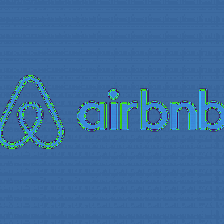

In [45]:
to_img = transforms.ToPILImage()
temp_img = to_img(Dataset[1][0])
temp_img

In [46]:
class NN(nn.Module):
  def __init__(self, in_channels, model_name):
    super().__init__()
    self.model_name = model_name
    self.model, self.out_dim_vgg16 = self.feature_extraction_vgg16(model_name=self.model_name)

  def feature_extraction_vgg16(self, model_name):

    # ---- Feature Extraction using vgg16 ----

    self.model = models.vgg16(pretrained=True)

    self.model = nn.Sequential(*list(self.model.features.children()))

    for params in self.model.parameters():
      params.requires_grad = False

    return self.model, 25088 # Output dimensions of vgg16.


  def forward(self, x):
    x = self.model(x)
    # output = self.my_NN_Denselayers(x, self.out_dim_vgg16)
    return x



In [47]:
model = NN(in_channels=3, model_name='vgg16')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [48]:
class DenseLayers(nn.Module):
  def __init__(self, feature_dim=25088):
        super().__init__()
        self.feature_dim = feature_dim
        self.fc1 = nn.Linear(in_features=self.feature_dim, out_features=128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 4)
        self.last_layer = nn.Linear(4, 1)

  def forward(self, x):
      x = nn.functional.relu(self.fc1(x))
      x = nn.functional.relu(self.fc2(x))
      x = nn.functional.relu(self.fc3(x))
      x = nn.Sigmoid()(self.last_layer(x))
      return x


In [49]:
my_Dense_layers = DenseLayers(feature_dim=25088)

In [13]:
def my_NN_Denselayers(x, feature_dim=25088):
  fc1 = nn.Linear(in_features = feature_dim, out_features=128)(x)
  fc2 = nn.Linear(128, 64)(fc1)
  fc3 = nn.Linear(64, 4)(fc2)
  last_layer = nn.Linear(4, 1)(fc3)
  output = nn.Sigmoid()(last_layer)
  return output

In [50]:
train_size = int(0.7 * len(Dataset))
val_size = int(0.15 * len(Dataset))
test_size = len(Dataset) - train_size - val_size

In [51]:
train_dataset, val_dataset, test_dataset = random_split(Dataset, [train_size, val_size, test_size])

In [28]:
len(train_dataset) /32

25.28125

In [52]:
train_loader = DataLoader(train_dataset, batch_size=32)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [17]:
len(train_loader)

26

In [18]:
# Testing Forward propogation pipeline

out1 = model(Dataset[0][0])
out2 = model(Dataset[0][1])

result = out1.view(-1) - out2.view(-1)

In [19]:
result.shape

torch.Size([25088])

In [20]:
my_Dense_layers(result)

tensor([0.5917], grad_fn=<SigmoidBackward0>)

In [53]:
model = model.to(device)
my_Dense_layers = my_Dense_layers.to(device)

In [54]:
loss_fn = nn.BCELoss()
optimizer = optim.Adam(my_Dense_layers.parameters(), lr=0.0001)
EPOCHS = 200

In [23]:
len(train_loader)

26

In [55]:
no_of_training_batch = len(train_loader)
no_of_validation_batch = len(val_loader)
no_of_testing_batch = len(test_loader)

In [56]:
losses = []
accuracies = []
val_accuracies = []
val_losses = []

for epoch in range(EPOCHS):
  print(f"---------- EPOCH {epoch+1} ----------")

  epoch_accuracy = 0.0
  epoch_loss = 0.0
  epoch_val_accuracy = 0.0
  epoch_val_loss = 0.0

  for batch in train_loader:

    accuracy = 0.0
    batch[0] = batch[0].to(device)
    batch[1] = batch[1].to(device)
    batch[2] = batch[2].to(device)

    output1 = model(batch[0])
    output2 = model(batch[1])
    output1 = torch.flatten(output1, start_dim=1)
    output2 = torch.flatten(output2, start_dim=1)
    result = output1 - output2
    output = my_Dense_layers(result)

    target = batch[2]
    target = target.float()
    target = target.unsqueeze(1)
    Loss = loss_fn(output, target)
    epoch_loss += Loss.item()
    # losses.append(Loss.item())

    predictions = (output > 0.95).int()
    correct = (predictions == target).sum().item()
    total = len(target)
    accuracy = correct / total
    epoch_accuracy += accuracy
    # accuracies.append(accuracy)
    # print(f"\n   TRAINING METRICS")
    # print(f"Loss : {Loss.item()}")
    # print(f"Accuracy : {accuracy}")


    Loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  print(f"\n   TRAINING METRICS")
  epoch_loss = epoch_loss / no_of_training_batch
  epoch_accuracy = epoch_accuracy / no_of_training_batch
  print(f"Loss : {epoch_loss}")
  print(f"Accuracy : {epoch_accuracy}")
  accuracies.append(epoch_accuracy)
  losses.append(epoch_loss)

  with torch.no_grad():
    for val_batch in val_loader:
      val_accuracy = 0.0
      val_batch[0] = val_batch[0].to(device)
      val_batch[1] = val_batch[1].to(device)
      val_batch[2] = val_batch[2].to(device)

      val_output1 = model(val_batch[0])
      val_output2 = model(val_batch[1])

      val_output1 = torch.flatten(val_output1, start_dim=1)
      val_output2 = torch.flatten(val_output2, start_dim=1)
      val_result = val_output1 - val_output2
      val_output = my_Dense_layers(val_result)

      val_target = val_batch[2]
      val_target = val_target.float()
      val_target = val_target.unsqueeze(1)
      val_Loss = loss_fn(val_output, val_target)
      epoch_val_loss += val_Loss.item()
      val_losses.append(val_Loss.item())

      val_preds = (val_output > 0.95).int()
      print(val_preds)
      val_correct = (val_preds  == val_target).sum().item()
      val_total = len(val_target)
      val_accuracy = val_correct / val_total
      epoch_val_accuracy += val_accuracy
      # val_accuracies.append(val_accuracy)

  print(f"\n   VALIDATION BATCH")
  epoch_val_loss = epoch_val_loss / no_of_validation_batch
  epoch_val_accuracy = epoch_val_accuracy / no_of_validation_batch
  print(f"Validation Loss : {epoch_val_loss}")
  print(f"Validation Accuracy : {epoch_val_accuracy}")
  val_accuracies.append(epoch_val_accuracy)
  val_losses.append(epoch_val_loss)



Streaming output truncated to the last 5000 lines.
Validation Loss : 0.015286714769899845
Validation Accuracy : 1.0
---------- EPOCH 150 ----------

   TRAINING METRICS
Loss : 0.0017667708227516133
Accuracy : 1.0
tensor([[0],
        [0],
        [0],
        [1],
        [0],
        [0],
        [0],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]], device='cuda:0', dtype=torch.int32)
tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [

In [31]:
no_of_testing_batch

6

In [57]:
test_Loss = 0.0
test_Accuracy = 0.0

with torch.no_grad():
  for test_batch in test_loader:
    test_batch[0] = test_batch[0].to(device)
    test_batch[1] = test_batch[1].to(device)
    test_batch[2] = test_batch[2].to(device)

    test_output1 = model(test_batch[0])
    test_output2 = model(test_batch[1])

    test_output1 = torch.flatten(test_output1, start_dim=1)
    test_output2 = torch.flatten(test_output2, start_dim=1)

    print(f"Shape of test_output1 : {test_output1.shape}")
    print(f"Shape of test_output2 : {test_output2.shape}")
    result = test_output1 - test_output2

    test_output = my_Dense_layers(result)
    test_target = test_batch[2]
    test_target = test_target.float()
    test_target = test_target.unsqueeze(1)
    test_loss = loss_fn(test_output, test_target)
    test_Loss += test_loss.item()
    test_preds = (test_output > 0.95).int()
    test_correct = (test_preds  == test_target).sum().item()
    test_total = len(test_target)
    test_accuracy = test_correct / test_total
    test_Accuracy += test_accuracy

  test_Loss = test_Loss / no_of_testing_batch
  test_Accuracy = test_Accuracy / no_of_testing_batch


print(f"   TESTING METRICS ")
print(f"Loss : {test_Loss}")
print(f"Accuracy : {test_Accuracy}")



Shape of test_output1 : torch.Size([32, 25088])
Shape of test_output2 : torch.Size([32, 25088])
Shape of test_output1 : torch.Size([32, 25088])
Shape of test_output2 : torch.Size([32, 25088])
Shape of test_output1 : torch.Size([26, 25088])
Shape of test_output2 : torch.Size([26, 25088])
   TESTING METRICS 
Loss : 0.0011572308042862762
Accuracy : 1.0


In [76]:
test_output

tensor([[2.1664e-07],
        [3.0793e-04],
        [2.3646e-06],
        [5.9279e-08],
        [2.7022e-04],
        [9.9103e-01],
        [9.2657e-09],
        [2.1191e-08],
        [5.5120e-04],
        [1.5120e-07],
        [6.7008e-06],
        [9.9103e-01],
        [7.4395e-07],
        [1.1767e-04],
        [5.4152e-05],
        [1.8353e-09],
        [1.1427e-03],
        [3.8598e-06],
        [2.4694e-05],
        [9.9103e-01],
        [1.3231e-09],
        [8.0609e-09],
        [1.2489e-07],
        [9.5486e-05],
        [1.2506e-10],
        [7.5530e-09]], device='cuda:0')

In [58]:
feature_extractor_model_path = '/content/drive/MyDrive/Brand_Impersonation_Detection_project/Visual Detection/Siamese_Model/feature_Extraction_model.pth'
Dense_model_path = '/content/drive/MyDrive/Brand_Impersonation_Detection_project/Visual Detection/Siamese_Model/MY_Dense_model.pth'

In [87]:
try:
  torch.save(model.state_dict(), feature_extractor_model_path)
except:
  print("Failed to save feature extractor")

try:
  torch.save(my_Dense_layers.state_dict(), Dense_model_path)
except:
  print("Failed to save Dense model")

In [109]:
# Prediction

image1 = '/content/drive/MyDrive/Brand_Impersonation_Detection_project/Visual Detection/logo-dataset/cloudfare.png'

image2  = '/content/car.jpeg'

label = 1 # because image is same.

img1 = Image.open(image1)
img2 = Image.open(image2)

img1 = img1.convert('RGB')
img2 = img2.convert('RGB')

image1 = transform(img1)
image2 = transform(img2)

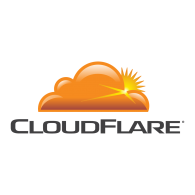

In [111]:
img1

In [112]:
image1 = image1.to(device)
image2 = image2.to(device)

model.eval()
first_output = model(image1)
second_output = model(image2)

In [113]:
first_output = torch.flatten(first_output, start_dim=0) # Because of No Batch Dimension
second_output = torch.flatten(second_output, start_dim=0)

In [114]:
prediction_result = first_output - second_output

In [54]:
print(first_output.shape)
print(second_output.shape)
print(prediction_result.shape)

torch.Size([25088])
torch.Size([25088])
torch.Size([25088])


In [115]:
my_Dense_layers.eval()
my_Dense_layers(prediction_result)

tensor([0.1911], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [108]:
# We have to set the threshold of 0.99 for same image. Less than this threshold image will not be same.
# Because on different images it sometimes give about 0.98 but for same image it gives 0.9910 i.e >0.99.